In [151]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve
#from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import *
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.combine import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib inline

In [152]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [153]:
def plot_roc_curve(fpr, tpr, model, color=None) :
    model = model + ' (auc = %0.3f)' % auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model, color=color)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR (1 - specificity)')
    plt.ylabel('TPR (recall)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

In [154]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [247]:

df = pd.read_csv('human.csv', encoding='cp949')
df.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [248]:

mdf = df.copy()

In [249]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   아이디     32561 non-null  object
 1   나이      32561 non-null  int64 
 2   노동 계급   30725 non-null  object
 3   fnlwgt  32561 non-null  int64 
 4   학력      32561 non-null  object
 5   교육 수    32561 non-null  int64 
 6   혼인 상태   32561 non-null  object
 7   직업      30718 non-null  object
 8   관계      32561 non-null  object
 9   인종      32561 non-null  object
 10  성별      32561 non-null  object
 11  자본 이득   32561 non-null  int64 
 12  자본 손실   32561 non-null  int64 
 13  주당 시간   32561 non-null  int64 
 14  모국      31978 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [250]:
mdf['주당 시간'].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: 주당 시간, Length: 94, dtype: int64

In [251]:
mdf['주당 시간'].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: 주당 시간, dtype: float64

In [252]:
mdf.loc[mdf['주당 시간'] <= 40]

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [253]:
mdf['주당 시간2']='a'
mdf.loc[mdf['주당 시간']<=30,'주당 시간2']='Lw'
mdf.loc[(mdf['주당 시간']>30)&(mdf['주당 시간']<=60),'주당 시간2']='Mw'
mdf.loc[(mdf['주당 시간']>60)&(mdf['주당 시간']<=90),'주당 시간2']='Hw'
mdf.loc[mdf['주당 시간']>90,'주당 시간2']='Vhw'
mdf

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국,주당 시간2
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,Mw
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,Lw
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,Mw
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,Mw
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,Mw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,Mw
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,Mw
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,Mw
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,Lw


In [254]:
mdf['혼인 상태'].head()

0          Never-married
1     Married-civ-spouse
2               Divorced
3     Married-civ-spouse
4     Married-civ-spouse
Name: 혼인 상태, dtype: object

In [255]:
mdf['혼인 상태'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: 혼인 상태, dtype: int64

In [256]:

mdf.loc[(mdf['혼인 상태'] == ' Never-married'), '혼인 상태2'] = 'Ma1'

In [257]:
mdf.loc[(mdf['혼인 상태'] == ' Married-civ-spouse') |
        (mdf['혼인 상태'] == ' Married-spouse-absent') |
        (mdf['혼인 상태'] == ' Married-AF-spouse'), '혼인 상태2'] = 'Ma2'

In [258]:
mdf.loc[(mdf['혼인 상태'] == ' Divorced') |
        (mdf['혼인 상태'] == ' Separated') |
        (mdf['혼인 상태'] == ' Widowed'), '혼인 상태2'] = 'Ma3'
mdf

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,Mw,Ma1
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,Lw,Ma2
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,Mw,Ma3
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,Mw,Ma2
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,Mw,Ma2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,Mw,Ma2
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,Mw,Ma2
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,Mw,Ma3
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,Lw,Ma1


'''mdf.loc[(mdf['관계'] == ' Husband')|
           (mdf['관계']==' Wife')|
           (mdf['관계']==' Own-child'),'관계2'] = 0
mdf.loc[(mdf['관계'] == ' Not-in-family')|
           (mdf['관계'] == ' Unmarried'),'관계2']=1
mdf.loc[(mdf['관계']==' Other-relative'),'관계2']=2
mdf'''

In [259]:
mdf.loc[(mdf.인종 ==' Other')|
                   (mdf.인종 ==' Amer-Indian-Eskimo')|
                   (mdf.인종 ==' Asian-Pac-Islander')|
                   (mdf.인종 ==' Black'), 'Not_white'] = 1
mdf.loc[(mdf.인종 ==' White'), 'Not_white'] = 0

In [260]:
mdf_n2 = pd.get_dummies(mdf['주당 시간2'])
mdf_n2.head()

,Hw,Lw,Mw,Vhw
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [261]:
mdf = pd.concat([mdf, mdf_n2], axis=1)
mdf

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,...,0,40,United-States,Mw,Ma1,0.0,0,0,1,0
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,...,0,13,United-States,Lw,Ma2,0.0,0,1,0,0
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,...,0,40,United-States,Mw,Ma2,1.0,0,0,1,0
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,...,0,40,Cuba,Mw,Ma2,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,...,0,38,United-States,Mw,Ma2,0.0,0,0,1,0
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,...,0,40,United-States,Mw,Ma2,0.0,0,0,1,0
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,...,0,20,United-States,Lw,Ma1,0.0,0,1,0,0


In [262]:
mdf

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,...,0,40,United-States,Mw,Ma1,0.0,0,0,1,0
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,...,0,13,United-States,Lw,Ma2,0.0,0,1,0,0
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,...,0,40,United-States,Mw,Ma2,1.0,0,0,1,0
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,...,0,40,Cuba,Mw,Ma2,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,...,0,38,United-States,Mw,Ma2,0.0,0,0,1,0
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,...,0,40,United-States,Mw,Ma2,0.0,0,0,1,0
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,...,0,20,United-States,Lw,Ma1,0.0,0,1,0,0


In [263]:
mdf[con]

,노동 계급,학력,혼인 상태,직업,관계,인종,모국
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Cuba
...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,United-States
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,United-States
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,United-States
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,United-States


#Hi_Ac = 

mdf.loc[(mdf['학력'] == 0)|
          (mdf['학력'] == 1)|
          (mdf['학력'] ==2)|
          (mdf['학력'] ==3)|
          (mdf['학력'] ==4)|
          (mdf['학력'] ==5)|
          (mdf['학력'] ==6)|
          (mdf['학력'] ==7)|
          (mdf['학력'] ==11)|
           (mdf['학력']==13),'Hi_Ac'] = 0
mdf.loc[(mdf['학력'] == 10)|
          (mdf['학력'] == 14)|
          (mdf['학력'] ==15)|
          (mdf['학력'] == 12)|
          (mdf['학력'] == 8)|
          (mdf['학력'] ==9),'Hi_Ac'] = 1
#Lo_Ac = 

mdf.loc[(mdf['학력'] !=10)|
           (mdf['학력'] !=9)|
           (mdf['학력'] !=12),'Master'] = 0

mdf.loc[(mdf['학력'] ==10)|
           (mdf['학력'] ==9)|
           (mdf['학력'] ==12),'Master'] = 1


In [264]:
mdf.isnull().sum()

아이디             0
나이              0
노동 계급        1836
fnlwgt          0
학력              0
교육 수            0
혼인 상태           0
직업           1843
관계              0
인종              0
성별              0
자본 이득           0
자본 손실           0
주당 시간           0
모국            583
주당 시간2          0
혼인 상태2          0
Not_white       0
Hw              0
Lw              0
Mw              0
Vhw             0
dtype: int64

In [265]:
imputer_con = SimpleImputer(strategy="most_frequent")  
con = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국']
mdf[con]=imputer_con.fit_transform(mdf[con])

In [269]:
mdf

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,...,0,40,United-States,Mw,Ma1,0.0,0,0,1,0
1,H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,...,0,13,United-States,Lw,Ma2,0.0,0,1,0,0
2,H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
3,H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,...,0,40,United-States,Mw,Ma2,1.0,0,0,1,0
4,H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,...,0,40,Cuba,Mw,Ma2,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,H52557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,...,0,38,United-States,Mw,Ma2,0.0,0,0,1,0
32557,H52558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,...,0,40,United-States,Mw,Ma2,0.0,0,0,1,0
32558,H52559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,...,0,40,United-States,Mw,Ma3,0.0,0,0,1,0
32559,H52560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,...,0,20,United-States,Lw,Ma1,0.0,0,1,0,0


In [118]:
obj = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '성별', '모국','주당 시간2', '혼인 상태2']

In [287]:
mdf[obj] = mdf[obj].apply(lambda x: x.astype('category').cat.codes)
mdf.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H20001,39,6,77516,9,13,4,0,1,4,...,0,40,38,2,0,0.0,0,0,1,0
1,H20002,50,5,83311,9,13,2,3,0,4,...,0,13,38,1,1,0.0,0,1,0,0
2,H20003,38,3,215646,11,9,0,5,1,4,...,0,40,38,2,2,0.0,0,0,1,0
3,H20004,53,3,234721,1,7,2,5,0,2,...,0,40,38,2,1,1.0,0,0,1,0
4,H20005,28,3,338409,9,13,2,9,5,2,...,0,40,4,2,1,1.0,0,0,1,0


In [288]:
corr=mdf.corr()


In [289]:
corr.성별.abs().sort_values(ascending=False)

성별           1.000000
관계           0.582454
주당 시간        0.229309
Lw           0.175432
Mw           0.130406
혼인 상태        0.129314
Not_white    0.103486
나이           0.088832
인종           0.087204
주당 시간2       0.086439
노동 계급        0.071584
혼인 상태2       0.069268
Hw           0.067643
자본 이득        0.048480
직업           0.047461
자본 손실        0.045567
학력           0.027356
fnlwgt       0.026858
Vhw          0.019560
교육 수         0.012280
모국           0.002061
Name: 성별, dtype: float64

In [290]:
corr=mdf.corr()
corr.성별.abs().sort_values(ascending=False)

성별           1.000000
관계           0.582454
주당 시간        0.229309
Lw           0.175432
Mw           0.130406
혼인 상태        0.129314
Not_white    0.103486
나이           0.088832
인종           0.087204
주당 시간2       0.086439
노동 계급        0.071584
혼인 상태2       0.069268
Hw           0.067643
자본 이득        0.048480
직업           0.047461
자본 손실        0.045567
학력           0.027356
fnlwgt       0.026858
Vhw          0.019560
교육 수         0.012280
모국           0.002061
Name: 성별, dtype: float64

In [291]:
mdfS=mdf.set_index('아이디')

In [292]:
from sklearn.model_selection import train_test_split  

X = mdfS.drop(['성별'], axis=1) 
Y = mdfS['성별']                    

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

https://greeksharifa.github.io/machine_learning/2019/12/09/Light-GBM/

In [293]:

scaler = MinMaxScaler()
scaler.fit(mdfS)

MinMaxScaler()

In [294]:
x = scaler.transform(mdfS)
mdfS = pd.DataFrame(x, columns=mdfS.columns)

In [295]:
mdf.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H20001,39,6,77516,9,13,4,0,1,4,...,0,40,38,2,0,0.0,0,0,1,0
1,H20002,50,5,83311,9,13,2,3,0,4,...,0,13,38,1,1,0.0,0,1,0,0
2,H20003,38,3,215646,11,9,0,5,1,4,...,0,40,38,2,2,0.0,0,0,1,0
3,H20004,53,3,234721,1,7,2,5,0,2,...,0,40,38,2,1,1.0,0,0,1,0
4,H20005,28,3,338409,9,13,2,9,5,2,...,0,40,4,2,1,1.0,0,0,1,0


In [296]:
mdfS.isnull().sum()

나이           0
노동 계급        0
fnlwgt       0
학력           0
교육 수         0
혼인 상태        0
직업           0
관계           0
인종           0
성별           0
자본 이득        0
자본 손실        0
주당 시간        0
모국           0
주당 시간2       0
혼인 상태2       0
Not_white    0
Hw           0
Lw           0
Mw           0
Vhw          0
dtype: int64

In [47]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

In [48]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [87]:
from sklearn.model_selection import train_test_split  

X = mdf.drop(['아이디','성별'], axis=1) 
Y = mdf['성별']                    

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=9, random_state=0)

In [51]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=0)

In [52]:
display(tree.score(X_test, y_test))

0.8303818200429931

findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


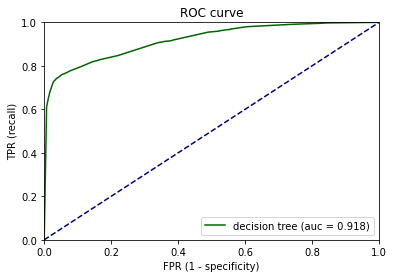

In [53]:
fpr_tree, tpr_tree, _ = roc_curve(y_test, 
                                  tree.predict_proba(X_test)[:,1])
plot_roc_curve(fpr_tree, tpr_tree, 'decision tree', 'darkgreen')

In [54]:
fpr, tpr, _ = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
auc(fpr, tpr)

0.9181977570759967

In [55]:
tree.score(X_test, y_test)

0.8303818200429931

In [56]:

import xgboost as xgb
from xgboost import plot_importance
#import pan
import numpy as np

In [57]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [58]:
params = {
         'learning_rate ': 0.01,
         'max_depth':3,
         'boosting' : 'gblinear',
         'objective':'binary:logistic',
         'metric':'binary_logloss',
         'is_training_metric':True,
         'num_leaves':144,
         'nrounds':1500,
         'feature_fraction':0.9,
         'bagging_fraction':0.7,
         'bagging_freq':5,
         'seed':2020}

         

num_rounds = 1000

In [59]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[12:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting, feature_fraction, is_training_metric, learning_rate , metric, nrounds, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.56307	eval-logloss:0.56405
[1]	train-logloss:0.49154	eval-logloss:0.49376
[2]	train-logloss:0.44616	eval-logloss:0.44954
[3]	train-logloss:0.41087	eval-logloss:0.41451
[

[153]	train-logloss:0.26112	eval-logloss:0.29422
[154]	train-logloss:0.26109	eval-logloss:0.29429
[155]	train-logloss:0.26104	eval-logloss:0.29424
[156]	train-logloss:0.26089	eval-logloss:0.29426
[157]	train-logloss:0.26066	eval-logloss:0.29418
[158]	train-logloss:0.26038	eval-logloss:0.29426
[159]	train-logloss:0.26023	eval-logloss:0.29416
[160]	train-logloss:0.26014	eval-logloss:0.29428
[161]	train-logloss:0.26009	eval-logloss:0.29429
[162]	train-logloss:0.25996	eval-logloss:0.29431
[163]	train-logloss:0.25983	eval-logloss:0.29431
[164]	train-logloss:0.25970	eval-logloss:0.29430
[165]	train-logloss:0.25958	eval-logloss:0.29424
[166]	train-logloss:0.25948	eval-logloss:0.29434
[167]	train-logloss:0.25923	eval-logloss:0.29432
[168]	train-logloss:0.25915	eval-logloss:0.29430
[169]	train-logloss:0.25906	eval-logloss:0.29431
[170]	train-logloss:0.25897	eval-logloss:0.29423
[171]	train-logloss:0.25876	eval-logloss:0.29416
[172]	train-logloss:0.25853	eval-logloss:0.29421
[173]	train-logloss:

[321]	train-logloss:0.23719	eval-logloss:0.29668
[322]	train-logloss:0.23715	eval-logloss:0.29675
[323]	train-logloss:0.23709	eval-logloss:0.29667
[324]	train-logloss:0.23708	eval-logloss:0.29671
[325]	train-logloss:0.23689	eval-logloss:0.29661
[326]	train-logloss:0.23675	eval-logloss:0.29669
[327]	train-logloss:0.23661	eval-logloss:0.29675
[328]	train-logloss:0.23647	eval-logloss:0.29669
[329]	train-logloss:0.23637	eval-logloss:0.29685
[330]	train-logloss:0.23636	eval-logloss:0.29686
[331]	train-logloss:0.23632	eval-logloss:0.29694
[332]	train-logloss:0.23616	eval-logloss:0.29691
[333]	train-logloss:0.23609	eval-logloss:0.29700
[334]	train-logloss:0.23586	eval-logloss:0.29682
[335]	train-logloss:0.23576	eval-logloss:0.29690
[336]	train-logloss:0.23559	eval-logloss:0.29688
[337]	train-logloss:0.23535	eval-logloss:0.29677
[338]	train-logloss:0.23505	eval-logloss:0.29673
[339]	train-logloss:0.23490	eval-logloss:0.29679
[340]	train-logloss:0.23481	eval-logloss:0.29679
[341]	train-logloss:

[489]	train-logloss:0.21910	eval-logloss:0.30011
[490]	train-logloss:0.21897	eval-logloss:0.29996
[491]	train-logloss:0.21884	eval-logloss:0.29995
[492]	train-logloss:0.21874	eval-logloss:0.30000
[493]	train-logloss:0.21867	eval-logloss:0.30002
[494]	train-logloss:0.21850	eval-logloss:0.29989
[495]	train-logloss:0.21842	eval-logloss:0.29995
[496]	train-logloss:0.21833	eval-logloss:0.29996
[497]	train-logloss:0.21826	eval-logloss:0.29991
[498]	train-logloss:0.21810	eval-logloss:0.30001
[499]	train-logloss:0.21805	eval-logloss:0.29999
[500]	train-logloss:0.21792	eval-logloss:0.30013
[501]	train-logloss:0.21785	eval-logloss:0.30003
[502]	train-logloss:0.21777	eval-logloss:0.30003
[503]	train-logloss:0.21771	eval-logloss:0.30001
[504]	train-logloss:0.21755	eval-logloss:0.29987
[505]	train-logloss:0.21751	eval-logloss:0.29988
[506]	train-logloss:0.21743	eval-logloss:0.29992
[507]	train-logloss:0.21742	eval-logloss:0.30000
[508]	train-logloss:0.21740	eval-logloss:0.30003
[509]	train-logloss:

[657]	train-logloss:0.20527	eval-logloss:0.30298
[658]	train-logloss:0.20511	eval-logloss:0.30300
[659]	train-logloss:0.20500	eval-logloss:0.30299
[660]	train-logloss:0.20496	eval-logloss:0.30308
[661]	train-logloss:0.20494	eval-logloss:0.30309
[662]	train-logloss:0.20484	eval-logloss:0.30300
[663]	train-logloss:0.20478	eval-logloss:0.30315
[664]	train-logloss:0.20470	eval-logloss:0.30312
[665]	train-logloss:0.20468	eval-logloss:0.30317
[666]	train-logloss:0.20464	eval-logloss:0.30319
[667]	train-logloss:0.20452	eval-logloss:0.30315
[668]	train-logloss:0.20440	eval-logloss:0.30319
[669]	train-logloss:0.20432	eval-logloss:0.30327
[670]	train-logloss:0.20427	eval-logloss:0.30328
[671]	train-logloss:0.20419	eval-logloss:0.30328
[672]	train-logloss:0.20408	eval-logloss:0.30331
[673]	train-logloss:0.20403	eval-logloss:0.30329
[674]	train-logloss:0.20398	eval-logloss:0.30329
[675]	train-logloss:0.20388	eval-logloss:0.30332
[676]	train-logloss:0.20376	eval-logloss:0.30338
[677]	train-logloss:

[825]	train-logloss:0.19269	eval-logloss:0.30611
[826]	train-logloss:0.19261	eval-logloss:0.30618
[827]	train-logloss:0.19254	eval-logloss:0.30624
[828]	train-logloss:0.19251	eval-logloss:0.30623
[829]	train-logloss:0.19250	eval-logloss:0.30623
[830]	train-logloss:0.19249	eval-logloss:0.30626
[831]	train-logloss:0.19244	eval-logloss:0.30636
[832]	train-logloss:0.19238	eval-logloss:0.30644
[833]	train-logloss:0.19226	eval-logloss:0.30650
[834]	train-logloss:0.19218	eval-logloss:0.30643
[835]	train-logloss:0.19211	eval-logloss:0.30632
[836]	train-logloss:0.19211	eval-logloss:0.30634
[837]	train-logloss:0.19203	eval-logloss:0.30651
[838]	train-logloss:0.19196	eval-logloss:0.30645
[839]	train-logloss:0.19187	eval-logloss:0.30649
[840]	train-logloss:0.19166	eval-logloss:0.30648
[841]	train-logloss:0.19161	eval-logloss:0.30656
[842]	train-logloss:0.19154	eval-logloss:0.30656
[843]	train-logloss:0.19153	eval-logloss:0.30658
[844]	train-logloss:0.19152	eval-logloss:0.30662
[845]	train-logloss:

[993]	train-logloss:0.18163	eval-logloss:0.30785
[994]	train-logloss:0.18159	eval-logloss:0.30782
[995]	train-logloss:0.18148	eval-logloss:0.30783
[996]	train-logloss:0.18143	eval-logloss:0.30783
[997]	train-logloss:0.18135	eval-logloss:0.30785
[998]	train-logloss:0.18129	eval-logloss:0.30784
[999]	train-logloss:0.18121	eval-logloss:0.30784


In [60]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.093 0.397 1.    1.    0.999 0.557 0.652 0.175 0.089 0.459]


In [61]:
get_clf_eval(y_test, preds)

오차행렬
[[2551  700]
 [ 799 5719]]
정확도: 0.8466, 정밀도: 0.8909, 재현율: 0.8774


#https://greatjoy.tistory.com/72
#lightgbm 설명

In [305]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train,label=y_train)
test_ds=lgb.Dataset(X_test,label=y_test)
params = {'learning_rate ': 0.01,
         'max_depth':3,
         'boosting' : 'gbdt',
         'objective':'binary',
         'metric':'binary_logloss',
         'is_training_metric':True,
         'num_leaves':144,
         'nrounds':1500,
         'feature_fraction':0.9,
         'bagging_fraction':0.7,
         'bagging_freq':5,
         'seed':2020}

model=lgb.train(params,train_ds,1000,test_ds,verbose_eval=100,early_stopping_rounds=3000)

[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Info] Number of positive: 15272, number of negative: 7520
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 22792, number of used features: 20
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670060 -> initscore=0.708455
[LightGBM] [Info] Start training from score 0.708455
Trai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's binary_logloss: 0.293726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[900]	valid_0's binary_logloss: 0.297855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [306]:
pred_probs = model.predict(X_test)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.08  0.494 0.999 1.    0.98  0.633 0.452 0.24  0.104 0.234]


In [307]:
get_clf_eval(y_test, preds)

오차행렬
[[2612  639]
 [ 861 5657]]
정확도: 0.8465, 정밀도: 0.8985, 재현율: 0.8679


In [308]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [309]:
new = pd.read_csv('human_new.csv', encoding='cp949')
new.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국
0,H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States
1,H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States
2,H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States
3,H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States
4,H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States


In [310]:
mdfS

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,0.301370,0.857143,0.044302,0.600000,0.800000,0.666667,0.000000,0.2,1.0,1.0,...,0.0,0.397959,0.95,0.666667,0.0,0.0,0.0,0.0,1.0,0.0
1,0.452055,0.714286,0.048238,0.600000,0.800000,0.333333,0.230769,0.0,1.0,1.0,...,0.0,0.122449,0.95,0.333333,0.5,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.428571,0.138113,0.733333,0.533333,0.000000,0.384615,0.2,1.0,1.0,...,0.0,0.397959,0.95,0.666667,1.0,0.0,0.0,0.0,1.0,0.0
3,0.493151,0.428571,0.151068,0.066667,0.400000,0.333333,0.384615,0.0,0.5,1.0,...,0.0,0.397959,0.95,0.666667,0.5,1.0,0.0,0.0,1.0,0.0
4,0.150685,0.428571,0.221488,0.600000,0.800000,0.333333,0.692308,1.0,0.5,0.0,...,0.0,0.397959,0.10,0.666667,0.5,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.428571,0.166404,0.466667,0.733333,0.333333,0.923077,1.0,1.0,0.0,...,0.0,0.377551,0.95,0.666667,0.5,0.0,0.0,0.0,1.0,0.0
32557,0.315068,0.428571,0.096500,0.733333,0.533333,0.333333,0.461538,0.0,1.0,1.0,...,0.0,0.397959,0.95,0.666667,0.5,0.0,0.0,0.0,1.0,0.0
32558,0.561644,0.428571,0.094827,0.733333,0.533333,1.000000,0.000000,0.8,1.0,0.0,...,0.0,0.397959,0.95,0.666667,1.0,0.0,0.0,0.0,1.0,0.0
32559,0.068493,0.428571,0.128499,0.733333,0.533333,0.666667,0.000000,0.6,1.0,1.0,...,0.0,0.193878,0.95,0.333333,0.0,0.0,0.0,1.0,0.0,0.0


In [311]:
X_train.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
아이디,,,,,,,,,,,,,,,,,,,,
H52099,45,3,170871,11,9,2,2,0,4,7298,0,60,38,2,1,0.0,0,0,1,0
H45207,47,6,108890,11,9,0,0,4,4,1831,0,38,38,2,2,0.0,0,0,1,0
H43492,48,3,187505,15,10,2,11,0,4,0,0,50,38,2,1,0.0,0,0,1,0
H32368,29,3,145592,11,9,4,2,1,4,0,0,40,12,2,0,0.0,0,0,1,0
H27055,23,3,203003,5,4,4,2,1,4,0,0,25,10,1,0,0.0,0,1,0,0


In [312]:
new['주당 시간2']='Lw'
new.loc[new['주당 시간']<=30,'주당 시간2']='Lw'
new.loc[(new['주당 시간']>30)&(new['주당 시간']<=60),'주당 시간2']='Mw'
new.loc[(new['주당 시간']>60)&(new['주당 시간']<=90),'주당 시간2']='Hw'
new.loc[new['주당 시간']>90,'주당 시간2']='Vhw'
new

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국,주당 시간2
0,H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States,Mw
1,H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States,Mw
2,H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,Mw
3,H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States,Mw
4,H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States,Lw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,H16277,20,NaN,216672,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States,Lw
16277,H16278,25,Private,61956,Bachelors,13,Never-married,Exec-managerial,Own-child,White,4650,0,45,United-States,Mw
16278,H16279,33,Private,157216,Masters,14,Never-married,Sales,Not-in-family,White,0,0,40,United-States,Mw
16279,H16280,68,NaN,150250,Masters,14,Married-civ-spouse,NaN,Husband,White,0,1510,30,United-States,Lw


In [313]:
new.loc[(new['혼인 상태'] == ' Never-married '), '혼인 상태2'] = 'Ma1'
new.loc[(new['혼인 상태'] == ' Married-civ-spouse') |
        (new['혼인 상태'] == ' Married-spouse-absent') |
        (new['혼인 상태'] == ' Married-AF-spouse'), '혼인 상태2'] = 'Ma2'
new.loc[(new['혼인 상태'] == ' Divorced') |
        (new['혼인 상태'] == ' Separated') |
        (new['혼인 상태'] == ' Widowed'), '혼인 상태2'] = 'Ma3'
new.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2
0,H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States,Mw,NaN
1,H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States,Mw,Ma2
2,H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,Mw,Ma2
3,H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States,Mw,Ma2
4,H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States,Lw,NaN


In [314]:
new.loc[(new.인종 ==' Other')|
                   (new.인종 ==' Amer-Indian-Eskimo')|
                   (new.인종 ==' Asian-Pac-Islander')|
                   (new.인종 ==' Black'), 'Not_white'] = 1
new.loc[(new.인종 ==' White'), 'Not_white'] = 0

#Hi_Ac = 

new.loc[(new['학력'] == 0)|
          (new['학력'] == 1)|
          (new['학력'] ==2)|
          (new['학력'] ==3)|
          (new['학력'] ==4)|
          (new['학력'] ==5)|
          (new['학력'] ==6)|
          (new['학력'] ==7)|
          (new['학력'] ==11)|
           (new['학력']==13),'Hi_Ac'] = 0
new.loc[(new['학력'] == 10)|
          (new['학력'] == 14)|
          (new['학력'] ==15)|
          (new['학력'] == 12)|
          (new['학력'] == 8)|
          (new['학력'] ==9),'Hi_Ac'] = 1
#Lo_Ac = 

new.loc[(new['학력'] !=10)|
           (new['학력'] !=9)|
           (new['학력'] !=12),'Master'] = 0

new.loc[(new['학력'] ==10)|
           (new['학력'] ==9)|
           (new['학력'] ==12),'Master'] = 1


In [315]:
new_n2 = pd.get_dummies(new['주당 시간2'])
# 합치기
new = pd.concat([new, new_n2], axis=1)
new

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,...,0,40,United-States,Mw,NaN,1.0,0,0,1,0
1,H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,...,0,50,United-States,Mw,Ma2,0.0,0,0,1,0
2,H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,...,0,40,United-States,Mw,Ma2,0.0,0,0,1,0
3,H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,...,0,40,United-States,Mw,Ma2,1.0,0,0,1,0
4,H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,...,0,30,United-States,Lw,NaN,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,H16277,20,NaN,216672,Some-college,10,Never-married,NaN,Own-child,White,...,0,30,United-States,Lw,NaN,0.0,0,1,0,0
16277,H16278,25,Private,61956,Bachelors,13,Never-married,Exec-managerial,Own-child,White,...,0,45,United-States,Mw,NaN,0.0,0,0,1,0
16278,H16279,33,Private,157216,Masters,14,Never-married,Sales,Not-in-family,White,...,0,40,United-States,Mw,NaN,0.0,0,0,1,0
16279,H16280,68,NaN,150250,Masters,14,Married-civ-spouse,NaN,Husband,White,...,1510,30,United-States,Lw,Ma2,0.0,0,1,0,0


In [316]:
new.isnull().sum()

아이디             0
나이              0
노동 계급         963
fnlwgt          0
학력              0
교육 수            0
혼인 상태           0
직업            966
관계              0
인종              0
자본 이득           0
자본 손실           0
주당 시간           0
모국            274
주당 시간2          0
혼인 상태2       5434
Not_white       0
Hw              0
Lw              0
Mw              0
Vhw             0
dtype: int64

In [317]:
new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   아이디        16281 non-null  object 
 1   나이         16281 non-null  int64  
 2   노동 계급      15318 non-null  object 
 3   fnlwgt     16281 non-null  int64  
 4   학력         16281 non-null  object 
 5   교육 수       16281 non-null  int64  
 6   혼인 상태      16281 non-null  object 
 7   직업         15315 non-null  object 
 8   관계         16281 non-null  object 
 9   인종         16281 non-null  object 
 10  자본 이득      16281 non-null  int64  
 11  자본 손실      16281 non-null  int64  
 12  주당 시간      16281 non-null  int64  
 13  모국         16007 non-null  object 
 14  주당 시간2     16281 non-null  object 
 15  혼인 상태2     10847 non-null  object 
 16  Not_white  16281 non-null  float64
 17  Hw         16281 non-null  uint8  
 18  Lw         16281 non-null  uint8  
 19  Mw         16281 non-null  uint8  
 20  Vhw   

In [319]:
from sklearn.impute import SimpleImputer
imputer_con = SimpleImputer(strategy="most_frequent")  
con = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국']
new[con]=imputer_con.fit_transform(new[con])

In [320]:
obj1 = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국','주당 시간2', '혼인 상태2']
new[obj1] = new[obj1].apply(lambda x: x.astype('category').cat.codes)
new.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H00001,25,3,226802,1,7,4,6,3,2,...,0,40,37,2,-1,1.0,0,0,1,0
1,H00002,38,3,89814,11,9,2,4,0,4,...,0,50,37,2,0,0.0,0,0,1,0
2,H00003,28,1,336951,7,12,2,10,0,4,...,0,40,37,2,0,0.0,0,0,1,0
3,H00004,44,3,160323,15,10,2,6,0,2,...,0,40,37,2,0,1.0,0,0,1,0
4,H00005,18,3,103497,15,10,4,9,3,4,...,0,30,37,1,-1,0.0,0,1,0,0


In [321]:
ndf = new.copy()
ndf.head()

,아이디,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,...,자본 손실,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw
0,H00001,25,3,226802,1,7,4,6,3,2,...,0,40,37,2,-1,1.0,0,0,1,0
1,H00002,38,3,89814,11,9,2,4,0,4,...,0,50,37,2,0,0.0,0,0,1,0
2,H00003,28,1,336951,7,12,2,10,0,4,...,0,40,37,2,0,0.0,0,0,1,0
3,H00004,44,3,160323,15,10,2,6,0,2,...,0,40,37,2,0,1.0,0,0,1,0
4,H00005,18,3,103497,15,10,4,9,3,4,...,0,30,37,1,-1,0.0,0,1,0,0


In [325]:
ndfS=ndf.set_index('아이디')

In [326]:
scaler = MinMaxScaler()
scaler.fit(ndfS)

MinMaxScaler()

In [327]:
x = scaler.transform(ndfS)
ndfS = pd.DataFrame(x, columns=ndfS.columns)

In [329]:
ndfS['성별']=model.predict(ndfS.loc[:,'나이':'Vhw'])

In [330]:
ndfS.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,...,주당 시간,모국,주당 시간2,혼인 상태2,Not_white,Hw,Lw,Mw,Vhw,성별
0,0.109589,0.428571,0.144430,0.066667,0.400000,0.666667,0.461538,0.6,0.5,0.000000,...,0.397959,0.948718,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.894816
1,0.287671,0.428571,0.051677,0.733333,0.533333,0.333333,0.307692,0.0,1.0,0.000000,...,0.500000,0.948718,0.666667,0.5,0.0,0.0,0.0,1.0,0.0,0.999845
2,0.150685,0.142857,0.219011,0.466667,0.733333,0.333333,0.769231,0.0,1.0,0.000000,...,0.397959,0.948718,0.666667,0.5,0.0,0.0,0.0,1.0,0.0,0.999845
3,0.369863,0.428571,0.099418,1.000000,0.600000,0.333333,0.461538,0.0,0.5,0.076881,...,0.397959,0.948718,0.666667,0.5,1.0,0.0,0.0,1.0,0.0,0.999859
4,0.013699,0.428571,0.060942,1.000000,0.600000,0.666667,0.692308,0.6,1.0,0.000000,...,0.295918,0.948718,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.892934


In [331]:
ndf_id=pd.concat([ndf['아이디'],ndfS['성별']],axis=1)

In [305]:
ndf_rename.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      16281 non-null  object 
 1   SEX     16281 non-null  float64
dtypes: float64(1), object(1)
memory usage: 254.5+ KB


In [306]:
ndf_rename = ndf_id.rename(columns={'아이디':'ID', '성별':'SEX'})
ndf_rename.head()

,ID,SEX
0,H00001,0.702541
1,H00002,0.999976
2,H00003,0.999968
3,H00004,0.999927
4,H00005,0.367400


In [307]:
ndf_rename.to_csv('test_2.csv', encoding='cp949', index=False)